## Importing Libraries

In [35]:
import pandas as pd
import numpy as np
import import_ipynb
import Data
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import copy

## Data Handling

In [36]:
df = pd.read_csv('Data Set for Assignment 1.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Training the Model

In [37]:
def fischer_train(train):
    tclass = train['diagnosis'].tolist()
    train = train.drop(columns = ['id', 'diagnosis'])
    
    lda = LinearDiscriminantAnalysis()
    lda.fit(train,tclass)
    
    omega = lda.coef_
    omega = omega[0].tolist()
    
    return omega

In [38]:
def train_proj(omega,train):
    
    tclass = train['diagnosis'].tolist()
    train = train.drop(columns = ['id', 'diagnosis'])
    
    #Now we project the Data to the hyperplane that we found above 
    mproj = []
    bproj = []
    
    for i in range(len(tclass)):
        if(tclass[i] == 'B'):
            sum = 0
            for j in range(len(omega)):
                sum = sum + omega[j] * train.iloc[i,j]
            bproj.append(sum)
        elif(tclass[i] == 'M'):
            sum = 0
            for j in range(len(omega)):
                sum = sum + omega[j] * train.iloc[i,j]
            mproj.append(sum)

    return bproj,mproj
 

In [39]:
def dec_boundary(bproj,mproj):
    #Now we try to find the boundary of separation
    b_mean = np.mean(bproj)
    m_mean = np.mean(mproj)
    b_stdev = np.std(bproj)
    m_stdev = np.std(mproj)
    
    x = np.linspace(30, 80, 10000)
    y = 1/(b_stdev * np.sqrt(2 * np.pi)) * np.exp(-(x - b_mean)**2 / (2 * b_stdev**2)) #corresponds to distribution of B
    z = 1/(m_stdev * np.sqrt(2 * np.pi)) * np.exp(-(x - m_mean)**2 / (2 * m_stdev**2)) #corresponds to distribution of M
    
    plt.plot(x, y, label= "Distribution of B")
    plt.plot(x, z, label = "Distribution of M")
    plt.legend(loc="upper right")
    plt.title("Distribution of Projected Points")
    plt.savefig("results/FLDM.jpg")
    plt.show()
    
    for i in range(len(y)):
        diff = y[i] - z[i]
        if(diff < 0):
            boundary = i
            break
    
    return x[boundary]

## Testing the Model

In [40]:
def fischer_test(test,omega,bound):
    teclass = test['diagnosis'].tolist()
    test = test.drop(columns = ['id', 'diagnosis'])
    proj = []
    true_b = 0
    true_m = 0
    false_b = 0
    false_m = 0
    for i in range(len(teclass)):
        sum = 0
        for j in range(len(omega)):
            sum = sum + omega[j] * test.iloc[i,j]
        proj.append(sum)
     
    prediction = []

    for i in range(len(proj)):
        if (proj[i] > bound):
            prediction.append('M')
        else:
            prediction.append('B')

    correct = 0

    for i in range(len(prediction)):
        if (prediction[i] == teclass[i]):
            correct = correct + 1
    
    for i in range(len(prediction)):
        if(prediction[i] == 'M' and prediction[i] == teclass[i]):
            true_m = true_m + 1

        elif(prediction[i] == 'M' and prediction[i] != teclass[i]):
            false_m = false_m + 1

        elif(prediction[i] == 'B' and prediction[i] == teclass[i]):
            true_b = true_b + 1

        elif(prediction[i] == 'B' and prediction[i] != teclass[i]):
            false_b = false_b + 1

    precision = true_m / (true_m + false_m)
    recall = true_m / (true_m + false_b)
    accuracy  = correct/len(prediction)
    
    return accuracy,recall,precision
    

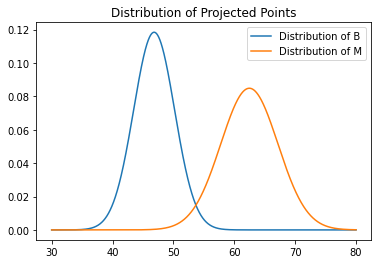

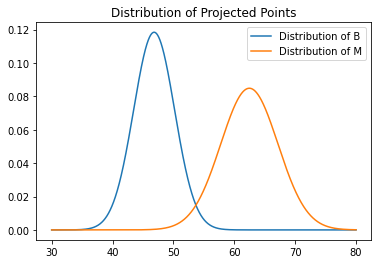

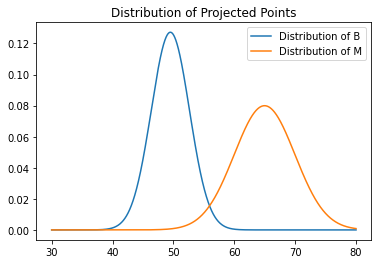

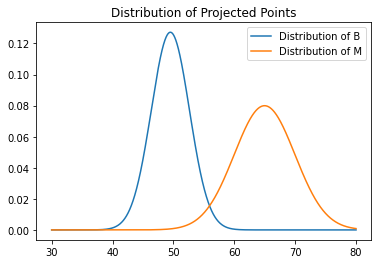

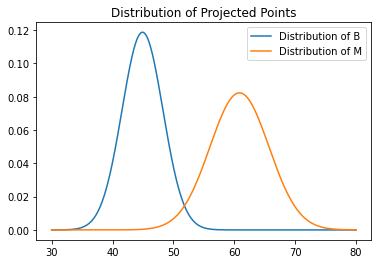

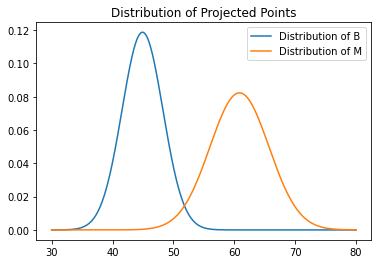

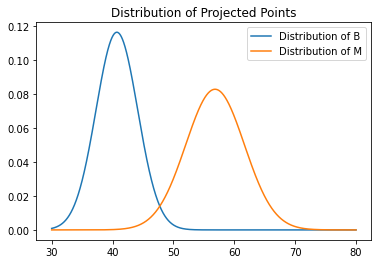

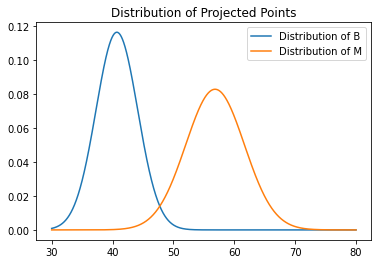

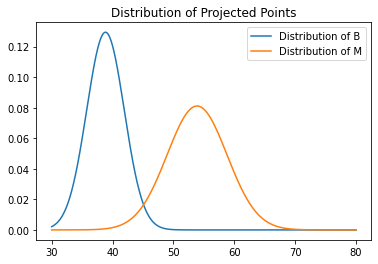

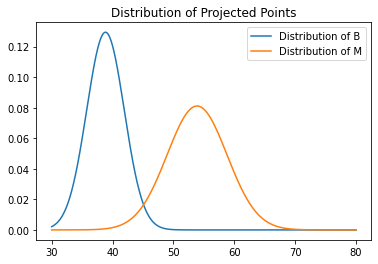

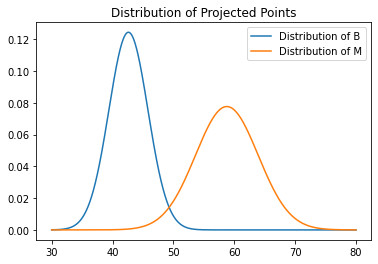

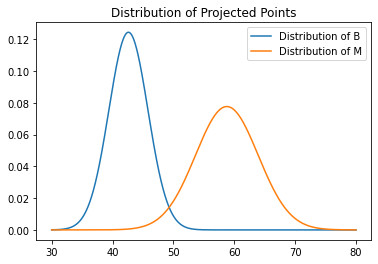

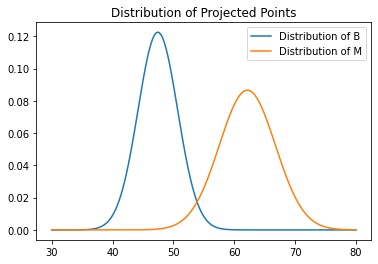

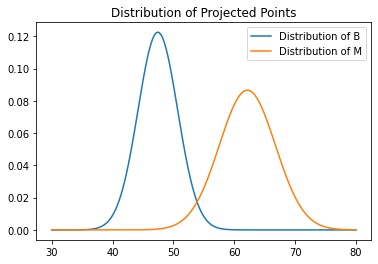

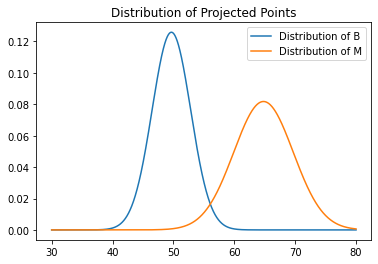

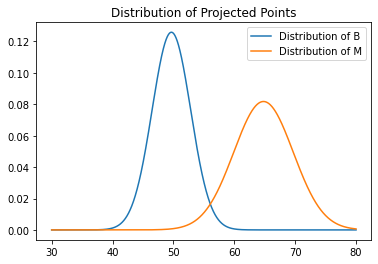

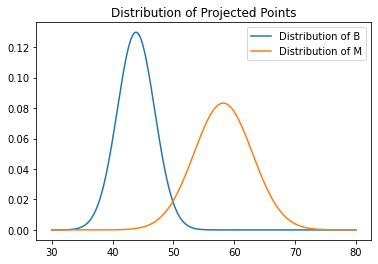

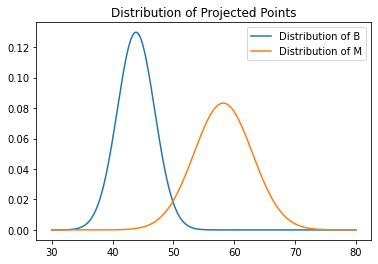

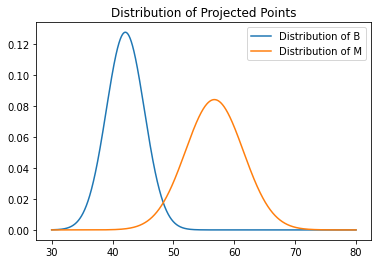

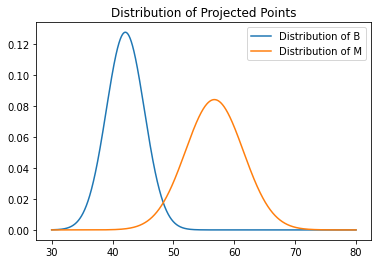

In [41]:
accuracy1 = []
accuracy2 = []
recall1 = []
recall2 = []
precision1 = []
precision2 = []
for i in range(10):
    initial_data = Data.data_fix(df)
    d1 = Data.dshuffle(initial_data)
    train1, test1 = Data.split(d1)
    c = Data.fshuffle(train1)
    train2 = copy.deepcopy(train1[c])
    test2 = copy.deepcopy(test1[c])
    
    omega1 = fischer_train(train1)
    bproj1, mproj1 = train_proj(omega1,train1)
    bound1 = dec_boundary(bproj1,mproj1)
    acc1, r1, p1 = fischer_test(test1,omega1,bound1)
    accuracy1.append(acc1)
    recall1.append(r1)
    precision1.append(p1)
    
    omega2 = fischer_train(train2)
    bproj2, mproj2 = train_proj(omega2,train2)
    bound2 = dec_boundary(bproj2,mproj2)
    acc2, r2, p2 = fischer_test(test2,omega2,bound2)
    accuracy2.append(acc2)
    recall2.append(r2)
    precision2.append(p2)

In [42]:
print("FLDM1 accuracy mean = ", np.mean(accuracy1))
print("FLDM1 accuracy variance = ", np.var(accuracy1))
print("FLDM1 recall = ", np.mean(recall1))
print("FLDM1 precision = ", np.mean(precision1))
print("FLDM2 accuracy mean = ", np.mean(accuracy2))
print("FLDM2 accuracy variance = ", np.var(accuracy2))
print("FLDM2 recall = ", np.mean(recall2))
print("FLDM2 precision = ", np.mean(precision2))

FLDM1 accuracy mean =  0.967741935483871
FLDM1 accuracy variance =  0.00010405827263267411
FLDM1 recall =  0.9446242271816724
FLDM1 precision =  0.9700988512701694
FLDM2 accuracy mean =  0.967741935483871
FLDM2 accuracy variance =  0.00010405827263267411
FLDM2 recall =  0.9446242271816724
FLDM2 precision =  0.9700988512701694


In [43]:
accuracy1 = pd.DataFrame(accuracy1, columns=["Accuracy of FLDM1"])
accuracy1.index += 1
accuracy2 = pd.DataFrame(accuracy2, columns=["Accuracy of FLDM2"])
accuracy2.index += 1

In [44]:
accuracy1.to_excel("results/accuracy_fldm1.xlsx")
accuracy2.to_excel("results/accuracy_fldm2.xlsx")

In [45]:
omega1 = pd.DataFrame(omega1,columns = ['Omega'])
omega1.to_excel('results/omega1.xlsx')

In [46]:
omega2 = pd.DataFrame(omega2,columns = ['Omega'])
omega2.to_excel('results/omega2.xlsx')